In [1]:
import kagglehub

path = kagglehub.dataset_download("PriYaa652/image-of-different-processed-rice-in-bd")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/image-of-different-processed-rice-in-bd


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


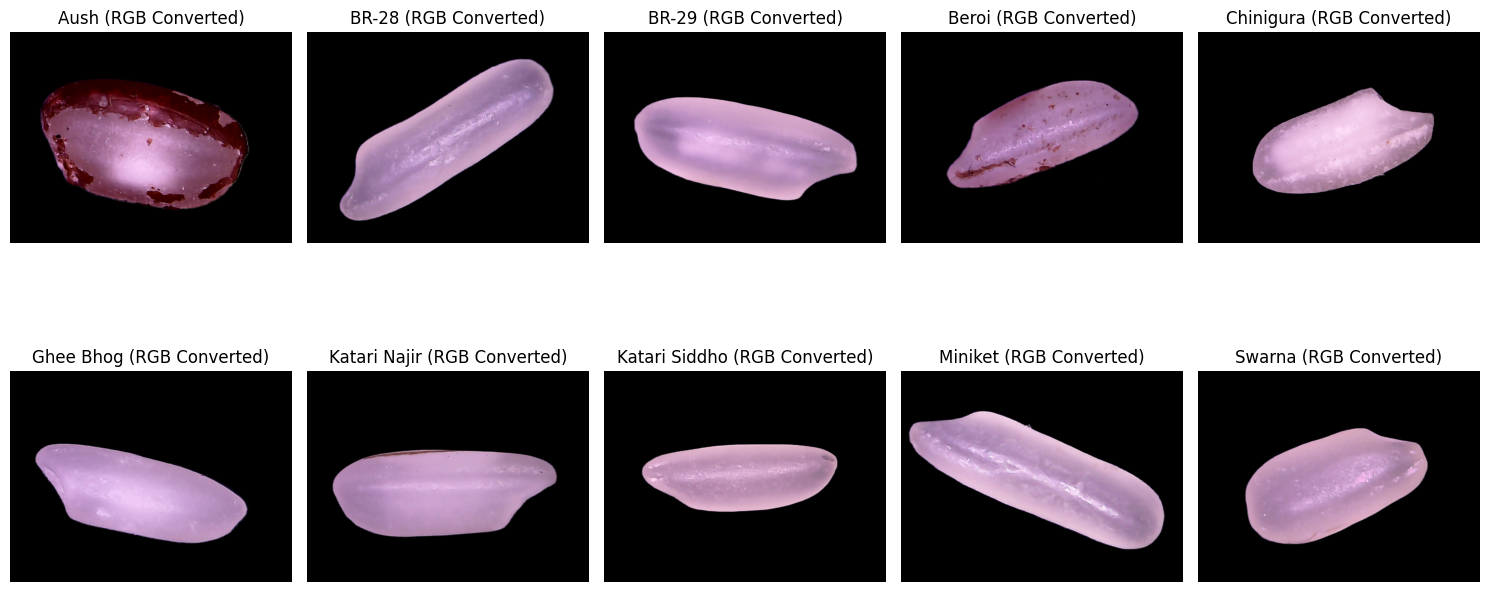

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

#  Function: RGBe → RGB (smooth, non-binary)
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

#  Folder paths
dataset_dir = "/kaggle/input/image-of-different-processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
import os
import shutil
import numpy as np
import time

dataset_dir = "/kaggle/input/image-of-different-processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'

# Force remove old directory (wait to ensure it's deleted)
if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)
    time.sleep(1)  # wait a bit so system finishes deleting

# Recreate clean structure
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
splits = ['train', 'val', 'test']

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# Perform split (20:80, 10% val of 20%)
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)
    total = len(images)

    # Calculate splits
    train_val_count = int(total * 0.2)      # 20% of total → Train + Val
    val_count = int(train_val_count * 0.1)  # 10% of 20% → Validation
    train_count = train_val_count - val_count
    test_count = total - train_val_count     # 80% of total → Test

    print(f"\nClass: {cls}")
    print(f"Total: {total}, Train: {train_count}, Val: {val_count}, Test: {test_count}")

    # Split images
    train_val_images = images[:train_val_count]
    test_images = images[train_val_count:]
    val_images = train_val_images[:val_count]
    train_images = train_val_images[val_count:]

    split_images = {'train': train_images, 'val': val_images, 'test': test_images}

    # Copy files
    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)

# ✅ Final Summary
print("\n=== Final Split Summary ===\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()



Class: Swarna
Total: 200, Train: 36, Val: 4, Test: 160

Class: Katari Siddho
Total: 200, Train: 36, Val: 4, Test: 160

Class: Beroi
Total: 200, Train: 36, Val: 4, Test: 160

Class: BR-29
Total: 200, Train: 36, Val: 4, Test: 160

Class: Katari Najir
Total: 200, Train: 36, Val: 4, Test: 160

Class: Miniket
Total: 200, Train: 36, Val: 4, Test: 160

Class: Chinigura
Total: 200, Train: 36, Val: 4, Test: 160

Class: Ghee Bhog
Total: 200, Train: 36, Val: 4, Test: 160

Class: BR-28
Total: 200, Train: 36, Val: 4, Test: 160

Class: Aush
Total: 200, Train: 36, Val: 4, Test: 160

=== Final Split Summary ===

--- TRAIN ---
Swarna: 36
Katari Siddho: 36
Beroi: 36
BR-29: 36
Katari Najir: 36
Miniket: 36
Chinigura: 36
Ghee Bhog: 36
BR-28: 36
Aush: 36

--- VAL ---
Swarna: 4
Katari Siddho: 4
Beroi: 4
BR-29: 4
Katari Najir: 4
Miniket: 4
Chinigura: 4
Ghee Bhog: 4
BR-28: 4
Aush: 4

--- TEST ---
Swarna: 160
Katari Siddho: 160
Beroi: 160
BR-29: 160
Katari Najir: 160
Miniket: 160
Chinigura: 160
Ghee Bhog: 160


2025-10-26 15:52:47.030188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761493967.195848      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761493967.257258      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 360 images belonging to 10 classes.
Found 40 images belonging to 10 classes.
Found 1600 images belonging to 10 classes.


I0000 00:00:1761493979.225592      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1761494016.000160     126 service.cc:148] XLA service 0x7ef8cc14fee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761494016.000899     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761494020.256976     126 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761494027.271179     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 - 74s - 6s/step - accuracy: 0.2833 - loss: 2.1956 - val_accuracy: 0.4500 - val_loss: 1.5526 - learning_rate: 0.0010
Epoch 2/50
12/12 - 3s - 255ms/step - accuracy: 0.6028 - loss: 1.2439 - val_accuracy: 0.6250 - val_loss: 1.1109 - learning_rate: 0.0010
Epoch 3/50
12/12 - 3s - 257ms/step - accuracy: 0.7222 - loss: 0.8725 - val_accuracy: 0.7000 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 4/50
12/12 - 3s - 252ms/step - accuracy: 0.7389 - loss: 0.7898 - val_accuracy: 0.7250 - val_loss: 0.7896 - learning_rate: 0.0010
Epoch 5/50
12/12 - 3s - 248ms/step - accuracy: 0.8139 - loss: 0.6443 - val_accuracy: 0.7000 - val_loss: 0.8516 - learning_rate: 0.0010
Epoch 6/50
12/12 - 3s - 250ms/step - accuracy: 0.8139 - loss: 0.6235 - val_accuracy: 0.7750 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 7/50
12/12 - 3s - 252ms/step - accuracy: 0.8583 - loss: 0.4996 - val_accuracy: 0.7000 - val_loss: 0.6657 - learning_rate: 0.0010
Epoch 8/50
12/12 - 3s - 254ms/step - accuracy: 0.8528 - loss: 0.5046

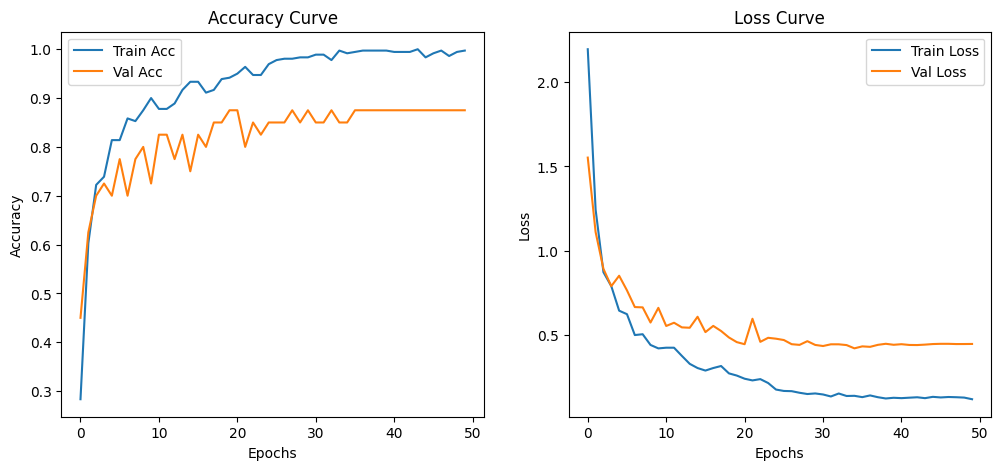


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9747    0.9625    0.9686       160
Katari Siddho     0.6222    0.7000    0.6588       160
        Beroi     0.7628    0.7438    0.7532       160
        BR-29     0.9551    0.9313    0.9430       160
 Katari Najir     0.9277    0.9625    0.9448       160
      Miniket     0.7831    0.8125    0.7975       160
    Chinigura     0.7764    0.7812    0.7788       160
    Ghee Bhog     0.7391    0.7438    0.7414       160
        BR-28     0.9301    0.8313    0.8779       160
         Aush     0.8824    0.8438    0.8626       160

     accuracy                         0.8313      1600
    macro avg     0.8354    0.8313    0.8327      1600
 weighted avg     0.8354    0.8313    0.8327      1600



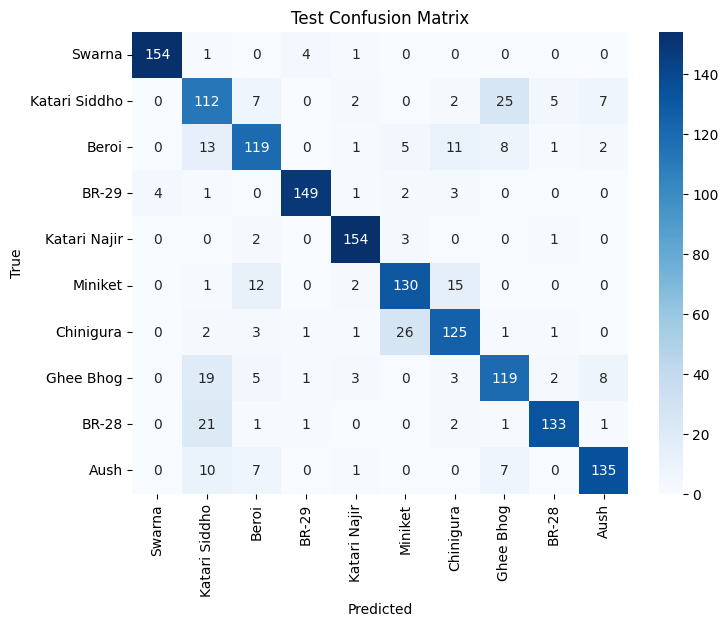

Swarna Accuracy: 0.9625
Katari Siddho Accuracy: 0.7000
Beroi Accuracy: 0.7438
BR-29 Accuracy: 0.9313
Katari Najir Accuracy: 0.9625
Miniket Accuracy: 0.8125
Chinigura Accuracy: 0.7812
Ghee Bhog Accuracy: 0.7438
BR-28 Accuracy: 0.8313
Aush Accuracy: 0.8438
Test AUC: 0.9834
Test PR AUC: 0.9024

Training Time: 223.97 seconds


In [7]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Paths and parameters

split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]


# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: NASNetMobile
# -----------------------------
def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (only LR scheduler, no early stop)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training (50 epochs, no early stop)
# -----------------------------
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")

Macro Precision: 0.8354
Macro Recall: 0.8313
Macro F1-score: 0.8327
Swarna: Precision=0.9747, Recall=0.9625, F1=0.9686
Katari Siddho: Precision=0.6222, Recall=0.7000, F1=0.6588
Beroi: Precision=0.7628, Recall=0.7438, F1=0.7532
BR-29: Precision=0.9551, Recall=0.9313, F1=0.9430
Katari Najir: Precision=0.9277, Recall=0.9625, F1=0.9448
Miniket: Precision=0.7831, Recall=0.8125, F1=0.7975
Chinigura: Precision=0.7764, Recall=0.7812, F1=0.7788
Ghee Bhog: Precision=0.7391, Recall=0.7438, F1=0.7414
BR-28: Precision=0.9301, Recall=0.8313, F1=0.8779
Aush: Precision=0.8824, Recall=0.8438, F1=0.8626


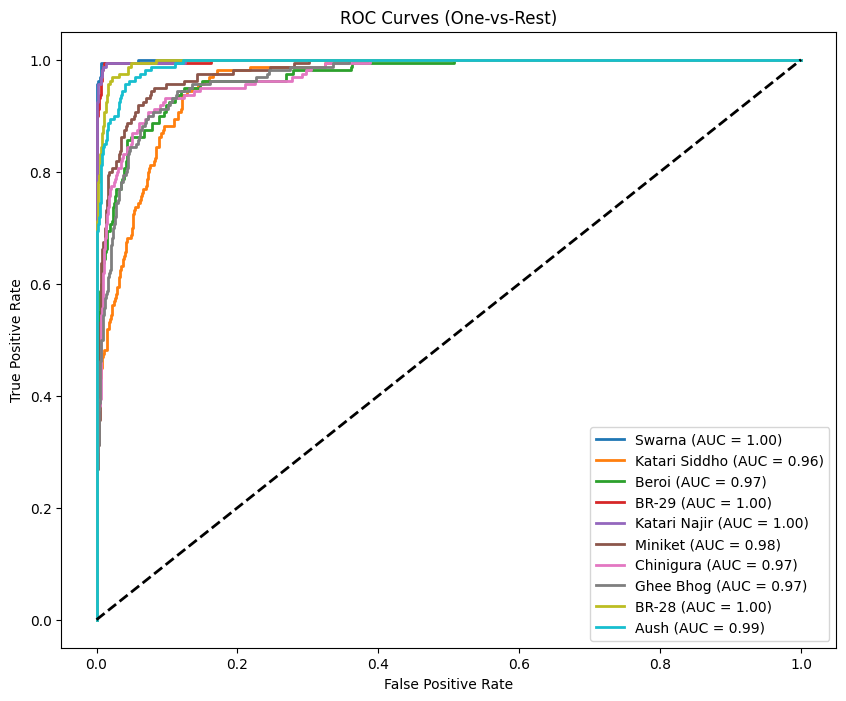

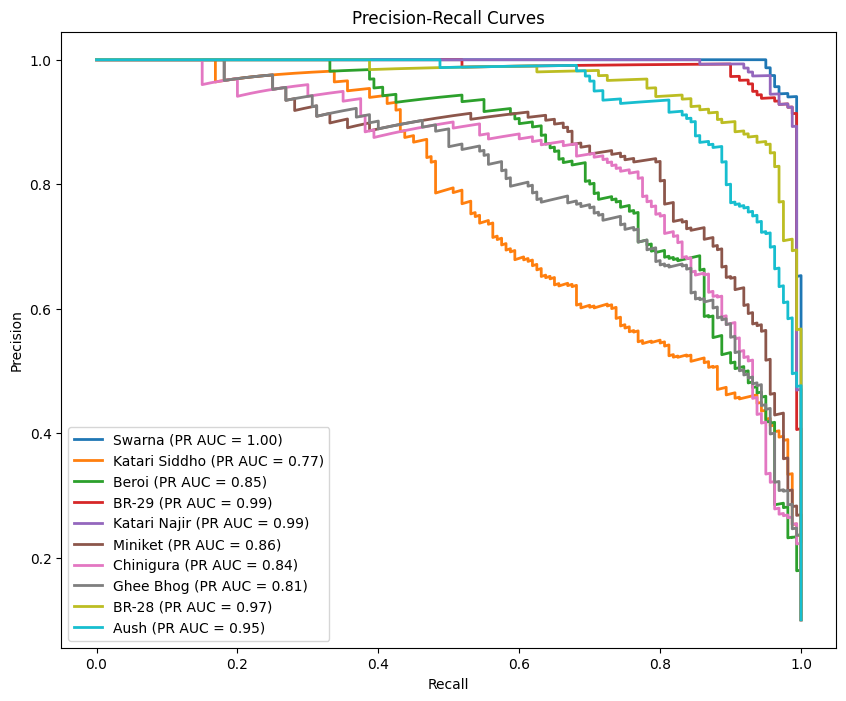

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 26.85 sec
Inference time per sample: 0.016784 sec

Most confused class pairs:
Swarna is most often confused with BR-29 (4 samples)
Katari Siddho is most often confused with Ghee Bhog (25 samples)
Beroi is most often confused with Katari Siddho (13 samples)
BR-29 is most often confused with Swarna (4 samples)
Katari Najir is most often confused with Miniket (3 samples)
Miniket is most often confused with Chinigura (15 samples)
Chinigura is most often confused with Miniket (26 samples)
Ghee Bhog is most often confused with Katari Siddho (19 samples)
BR-28 is most often confused with Katari Siddho (21 samples)
Aush is most often confused with Katari Siddho (10 samples)


In [8]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile

# -----------------------------
# Assume you already have:
# test_true: true labels (as integers)
# test_pred_prob: predicted probabilities from model.predict
# test_pred: predicted class labels (argmax of test_pred_prob)
# classes: list of class names
# num_classes: total number of classes
# -----------------------------

# -----------------------------
# Macro metrics
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro', zero_division=0)
macro_recall = recall_score(test_true, test_pred, average='macro', zero_division=0)
macro_f1 = f1_score(test_true, test_pred, average='macro', zero_division=0)

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_precision = precision_score(test_true, test_pred, average=None, zero_division=0)
per_class_recall = recall_score(test_true, test_pred, average=None, zero_division=0)
per_class_f1 = f1_score(test_true, test_pred, average=None, zero_division=0)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision-Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Inference time per sample
# -----------------------------
nasnet_model = NASNetMobile(weights='imagenet', include_top=False)  # dummy, replace with your trained model
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)  # test_gen = your test generator
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [9]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.007815 seconds


In [10]:
# Calculate and print the number of parameters
total_params = nasnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 4,269,716
Trainable Parameters: 4,232,978
Non-Trainable Parameters: 36,738


Found 330 images belonging to 10 classes.
Found 30 images belonging to 10 classes.
Found 1600 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
11/11 - 31s - 3s/step - accuracy: 0.2818 - loss: 2.1429 - val_accuracy: 0.5000 - val_loss: 1.5650 - learning_rate: 0.0010
Epoch 2/50
11/11 - 7s - 649ms/step - accuracy: 0.5152 - loss: 1.5395 - val_accuracy: 0.5333 - val_loss: 1.2280 - learning_rate: 0.0010
Epoch 3/50
11/11 - 7s - 649ms/step - accuracy: 0.6152 - loss: 1.2611 - val_accuracy: 0.7000 - val_loss: 1.0705 - learning_rate: 0.0010
Epoch 4/50
11/11 - 7s - 637ms/step - accuracy: 0.6667 - loss: 1.0658 - val_accuracy: 0.7667 - val_loss: 0.8532 - learning_rate: 0.0010
Epoch 5/50
11/11 - 7s - 594ms/step - accuracy: 0.7273 - loss: 0.8849 - val_accuracy: 0.7000 - val_loss: 0.8430 - learning_rate: 0.0010
Epoch 6/50
11/11 - 7s - 643ms/step - accuracy: 0.7606 - loss: 0.8417 - val_accuracy: 0.8000 - val_loss: 0.6772 - learning_rate: 0.0010
Epoch 7/50
11/11 - 6s - 589ms/step - accuracy: 0.7273 - loss: 0.8212 - val_accuracy: 0.7667 - val_loss: 0.7226 - learning_rate: 0.0010
Epoch 8/50
11/11 - 7s - 634ms/step - accuracy: 0.7606 - l

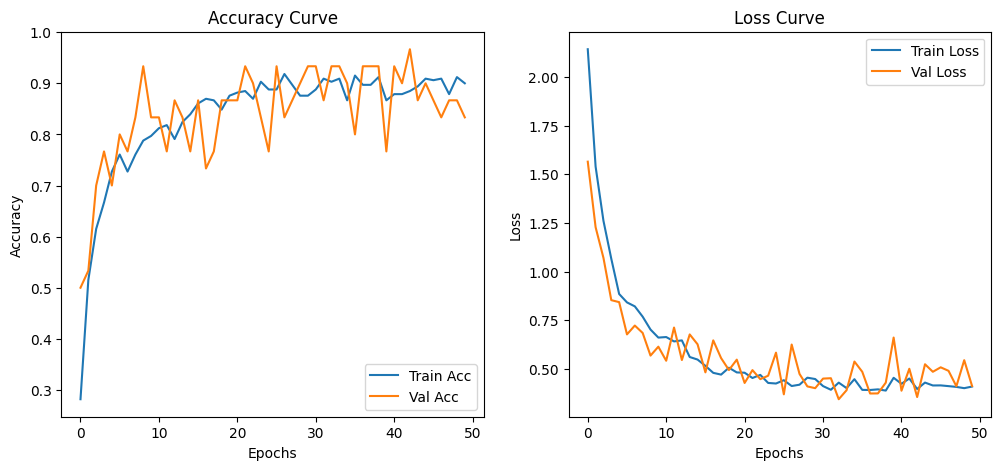


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9679    0.9437    0.9557       160
Katari Siddho     0.5141    0.8000    0.6259       160
        Beroi     0.8485    0.7000    0.7671       160
        BR-29     0.9273    0.9563    0.9415       160
 Katari Najir     1.0000    0.9812    0.9905       160
      Miniket     0.6912    0.9375    0.7958       160
    Chinigura     0.9326    0.5188    0.6667       160
    Ghee Bhog     0.6820    0.9250    0.7851       160
        BR-28     1.0000    0.5563    0.7149       160
         Aush     0.9225    0.7438    0.8235       160

     accuracy                         0.8062      1600
    macro avg     0.8486    0.8063    0.8067      1600
 weighted avg     0.8486    0.8063    0.8067      1600



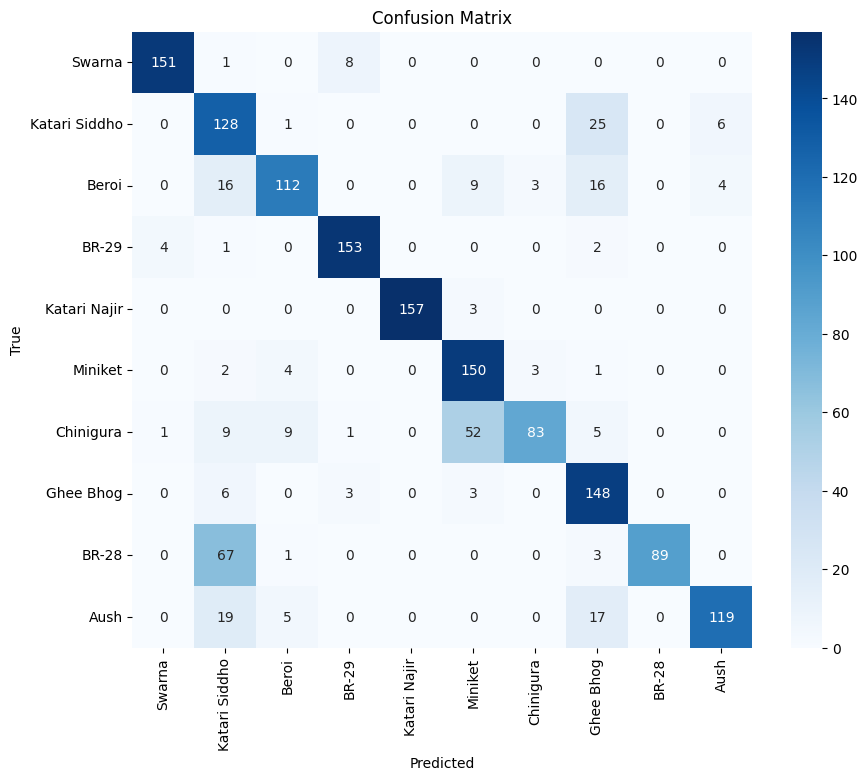

Swarna Accuracy: 0.9437
Katari Siddho Accuracy: 0.8000
Beroi Accuracy: 0.7000
BR-29 Accuracy: 0.9563
Katari Najir Accuracy: 0.9812
Miniket Accuracy: 0.9375
Chinigura Accuracy: 0.5188
Ghee Bhog Accuracy: 0.9250
BR-28 Accuracy: 0.5563
Aush Accuracy: 0.7438
Test AUC: 0.9869
Test PR AUC: 0.9199

Total Training Time: 290.07 seconds


In [14]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
dataset_dir = "/kaggle/input/image-of-different-processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data Generators with Augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.1  # 10% validation from 20% train+val
)

train_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    split_base_dir+'/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Compute class weights
# -----------------------------
train_labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# -----------------------------
# Build ConvNeXtTiny model
# -----------------------------
def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_convnext_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# -----------------------------
# Training (Frozen backbone) - 50 epochs
# -----------------------------
start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,   # 50 epochs frozen
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Fine-tuning (last 20 layers)
# -----------------------------
convnext_model.trainable = True
for layer in convnext_model.layers[:-20]:
    layer.trainable = False

convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,   # fine-tuning for 10 epochs
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTotal Training Time: {training_time:.2f} seconds")


Macro Precision: 0.8486
Macro Recall: 0.8063
Macro F1-score: 0.8067
Swarna: Precision=0.9679, Recall=0.9437, F1=0.9557
Katari Siddho: Precision=0.5141, Recall=0.8000, F1=0.6259
Beroi: Precision=0.8485, Recall=0.7000, F1=0.7671
BR-29: Precision=0.9273, Recall=0.9563, F1=0.9415
Katari Najir: Precision=1.0000, Recall=0.9812, F1=0.9905
Miniket: Precision=0.6912, Recall=0.9375, F1=0.7958
Chinigura: Precision=0.9326, Recall=0.5188, F1=0.6667
Ghee Bhog: Precision=0.6820, Recall=0.9250, F1=0.7851
BR-28: Precision=1.0000, Recall=0.5563, F1=0.7149
Aush: Precision=0.9225, Recall=0.7438, F1=0.8235


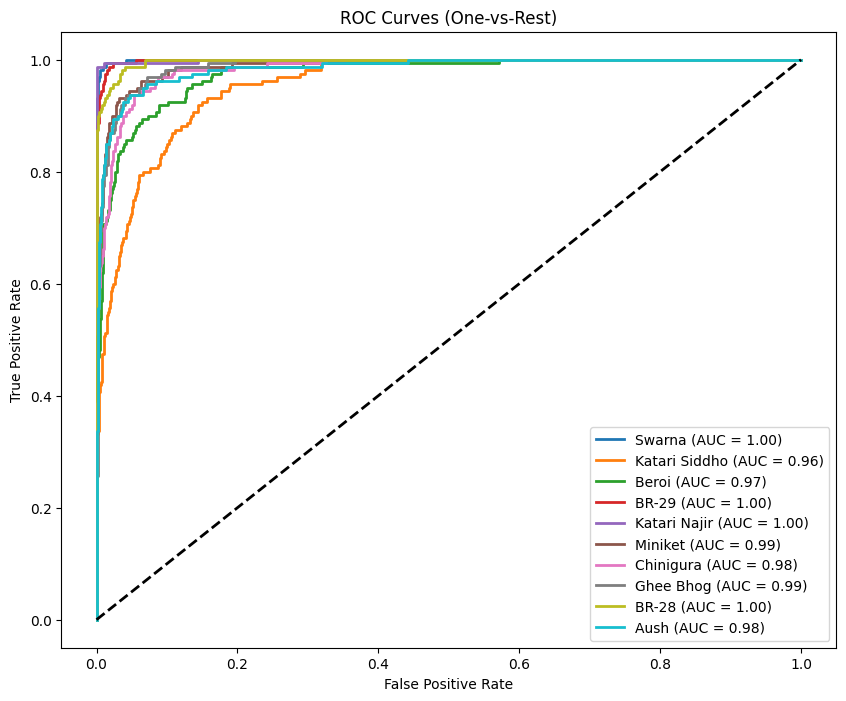

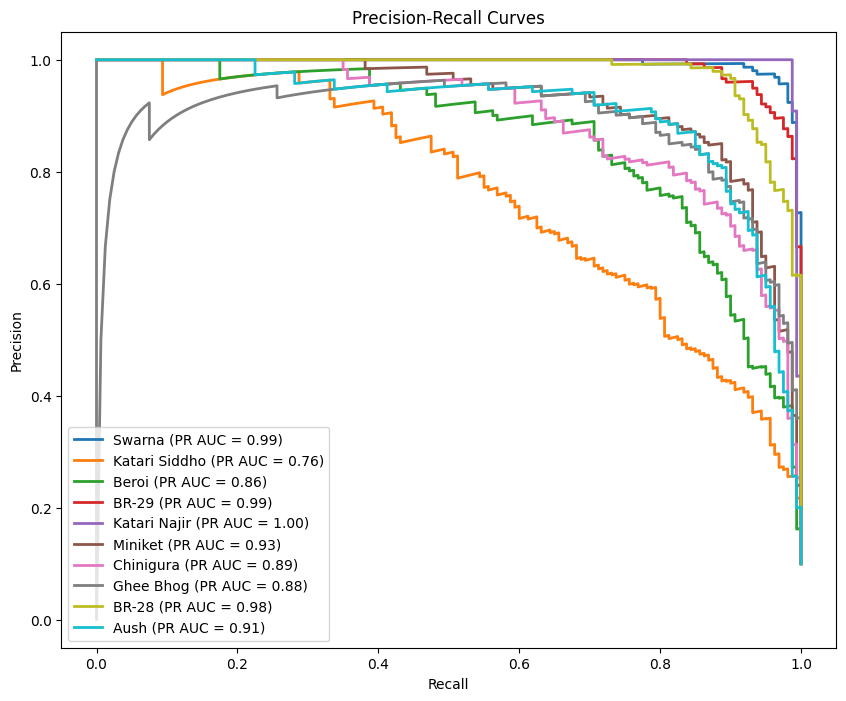


Most confused class pairs:
Swarna is most often confused with BR-29 (8 samples)
Katari Siddho is most often confused with Ghee Bhog (25 samples)
Beroi is most often confused with Katari Siddho (16 samples)
BR-29 is most often confused with Swarna (4 samples)
Katari Najir is most often confused with Miniket (3 samples)
Miniket is most often confused with Beroi (4 samples)
Chinigura is most often confused with Miniket (52 samples)
Ghee Bhog is most often confused with Katari Siddho (6 samples)
BR-28 is most often confused with Katari Siddho (67 samples)
Aush is most often confused with Katari Siddho (19 samples)


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [16]:
start_test = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.009392 seconds


In [17]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 4,232,978
Non-Trainable Parameters: 36,738


Found 360 images belonging to 10 classes.
Found 40 images belonging to 10 classes.
Found 1600 images belonging to 10 classes.
Epoch 1/50
12/12 - 37s - 3s/step - accuracy: 0.2806 - loss: 2.2910 - val_accuracy: 0.4750 - val_loss: 1.3668 - learning_rate: 0.0010
Epoch 2/50
12/12 - 10s - 854ms/step - accuracy: 0.5750 - loss: 1.3076 - val_accuracy: 0.7750 - val_loss: 0.9262 - learning_rate: 0.0010
Epoch 3/50
12/12 - 10s - 856ms/step - accuracy: 0.6389 - loss: 1.0578 - val_accuracy: 0.7250 - val_loss: 0.8344 - learning_rate: 0.0010
Epoch 4/50
12/12 - 10s - 860ms/step - accuracy: 0.6806 - loss: 0.9069 - val_accuracy: 0.7250 - val_loss: 0.7034 - learning_rate: 0.0010
Epoch 5/50
12/12 - 10s - 852ms/step - accuracy: 0.7250 - loss: 0.8475 - val_accuracy: 0.8750 - val_loss: 0.6159 - learning_rate: 0.0010
Epoch 6/50
12/12 - 10s - 840ms/step - accuracy: 0.7583 - loss: 0.7590 - val_accuracy: 0.8750 - val_loss: 0.6056 - learning_rate: 0.0010
Epoch 7/50
12/12 - 10s - 843ms/step - accuracy: 0.7528 - loss

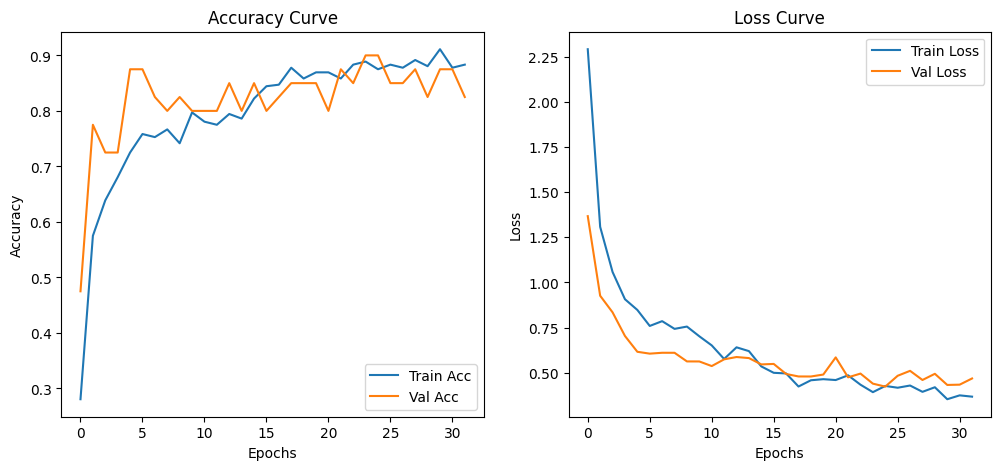


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9329    0.9563    0.9444       160
Katari Siddho     0.4789    0.8500    0.6126       160
        Beroi     0.8792    0.8187    0.8479       160
        BR-29     0.9613    0.9313    0.9460       160
 Katari Najir     0.9627    0.9688    0.9657       160
      Miniket     0.7241    0.9187    0.8099       160
    Chinigura     0.8362    0.6062    0.7029       160
    Ghee Bhog     0.9059    0.4813    0.6286       160
        BR-28     0.8759    0.7500    0.8081       160
         Aush     0.8151    0.7438    0.7778       160

     accuracy                         0.8025      1600
    macro avg     0.8372    0.8025    0.8044      1600
 weighted avg     0.8372    0.8025    0.8044      1600



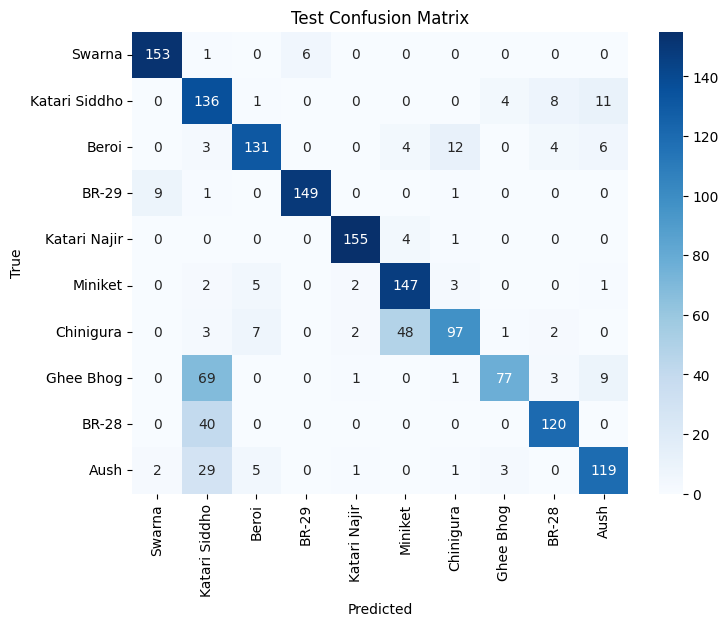

Swarna Accuracy: 0.9563
Katari Siddho Accuracy: 0.8500
Beroi Accuracy: 0.8187
BR-29 Accuracy: 0.9313
Katari Najir Accuracy: 0.9688
Miniket Accuracy: 0.9187
Chinigura Accuracy: 0.6062
Ghee Bhog Accuracy: 0.4813
BR-28 Accuracy: 0.7500
Aush Accuracy: 0.7438
Macro Precision: 0.8372, Macro Recall: 0.8025, Macro F1-score: 0.8044


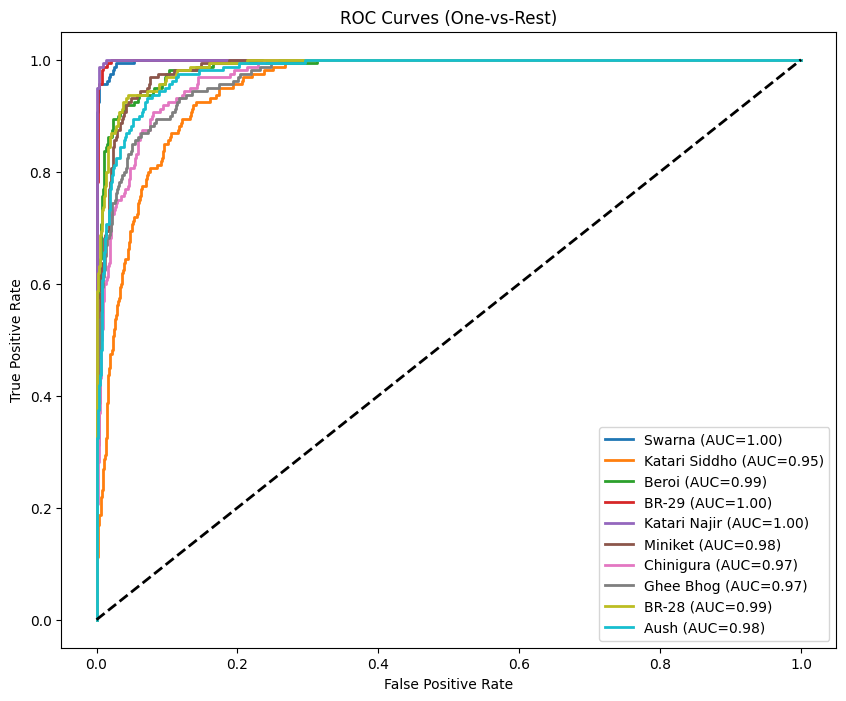

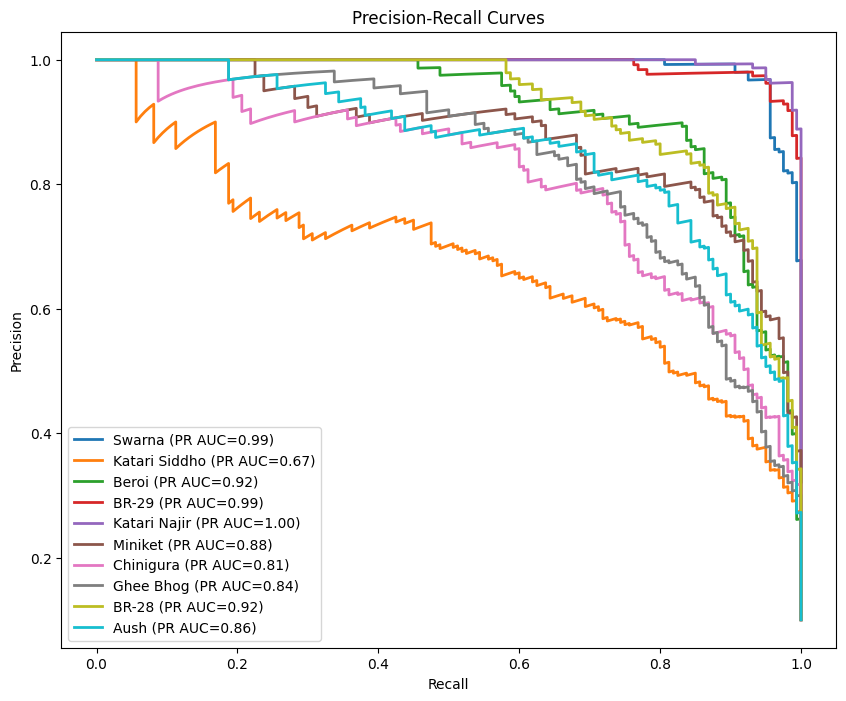


Most confused class pairs:
Swarna is most often confused with BR-29 (6 samples)
Katari Siddho is most often confused with Aush (11 samples)
Beroi is most often confused with Chinigura (12 samples)
BR-29 is most often confused with Swarna (9 samples)
Katari Najir is most often confused with Miniket (4 samples)
Miniket is most often confused with Beroi (5 samples)
Chinigura is most often confused with Miniket (48 samples)
Ghee Bhog is most often confused with Katari Siddho (69 samples)
BR-28 is most often confused with Katari Siddho (40 samples)
Aush is most often confused with Katari Siddho (29 samples)


In [26]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/image-of-different-processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (299, 299)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators with augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build InceptionV3 model
# -----------------------------
def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model, base_model = build_inception_model(num_classes=num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Train model for 50 epochs with early stopping
# -----------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, model)

# -----------------------------
# Classification report & confusion matrix
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC-AUC & PR Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused classes
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [27]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.012373 seconds


In [28]:

# Model parameter summary
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Total Parameters: 22,857,002
Trainable Parameters: 1,054,218
Non-Trainable Parameters: 21,802,784


Found 360 images belonging to 10 classes.
Found 40 images belonging to 10 classes.
Found 1600 images belonging to 10 classes.
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to best_resnet50_model.h5
23/23 - 41s - 2s/step - accuracy: 0.1944 - loss: 2.2297 - val_accuracy: 0.1000 - val_loss: 2.6715 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.10000
23/23 - 7s - 291ms/step - accuracy: 0.2472 - loss: 2.0749 - val_accuracy: 0.1000 - val_loss: 2.4838 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_accuracy improved from 0.10000 to 0.25000, saving model to best_resnet50_model.h5
23/23 - 8s - 328ms/step - accuracy: 0.2972 - loss: 1.9557 - val_accuracy: 0.2500 - val_loss: 2.2336 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_accuracy improved from 0.25000 to 0.30000, saving model to best_resnet50_model.h5
23/23 - 7s - 325ms/step - accuracy: 0.2889 - loss: 1.9485 - val_accuracy: 0.3000 - val_loss: 2.1705 - learning_

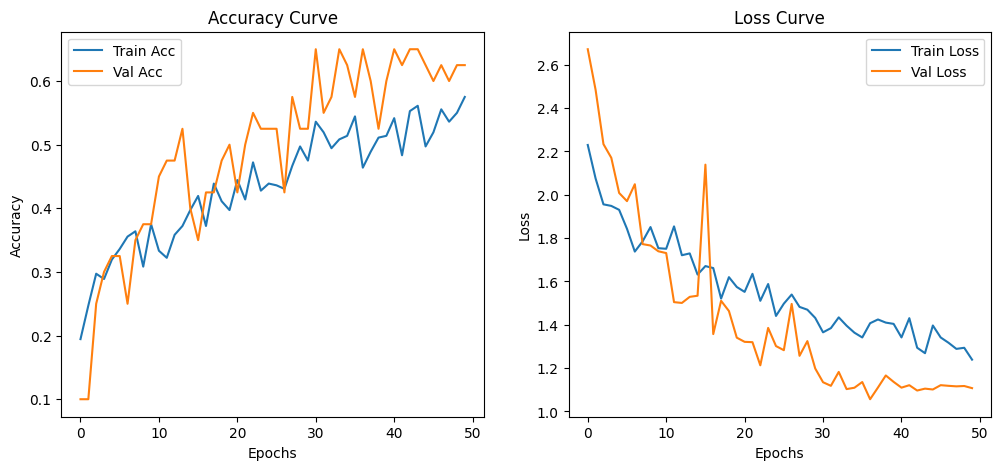


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.8678    0.9437    0.9042       160
Katari Siddho     0.5000    0.2250    0.3103       160
        Beroi     0.5294    0.4500    0.4865       160
        BR-29     0.9771    0.8000    0.8797       160
 Katari Najir     0.9633    0.6562    0.7807       160
      Miniket     0.3697    0.9313    0.5293       160
    Chinigura     0.6957    0.2000    0.3107       160
    Ghee Bhog     0.7320    0.4437    0.5525       160
        BR-28     0.6558    0.8812    0.7520       160
         Aush     0.6406    0.8688    0.7374       160

     accuracy                         0.6400      1600
    macro avg     0.6931    0.6400    0.6243      1600
 weighted avg     0.6931    0.6400    0.6243      1600



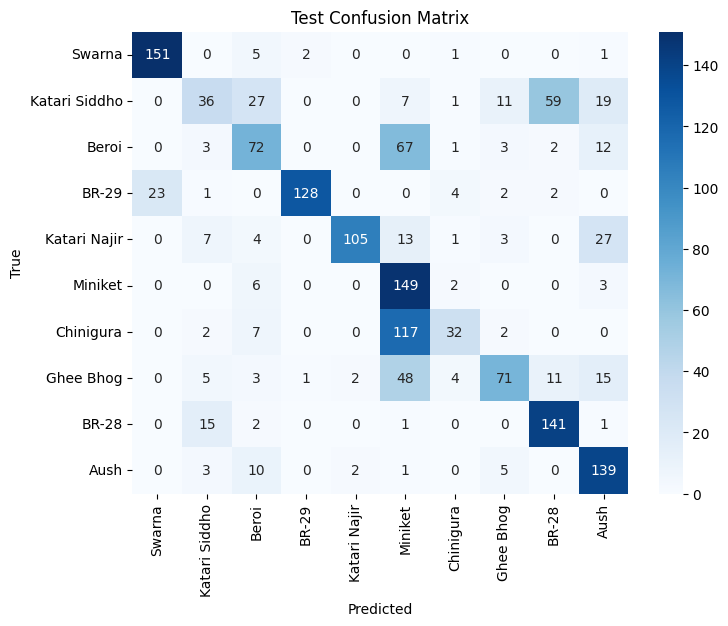

Swarna Accuracy: 0.9437
Katari Siddho Accuracy: 0.2250
Beroi Accuracy: 0.4500
BR-29 Accuracy: 0.8000
Katari Najir Accuracy: 0.6562
Miniket Accuracy: 0.9313
Chinigura Accuracy: 0.2000
Ghee Bhog Accuracy: 0.4437
BR-28 Accuracy: 0.8812
Aush Accuracy: 0.8688

Macro Precision: 0.6931
Macro Recall: 0.6400
Macro F1-score: 0.6243


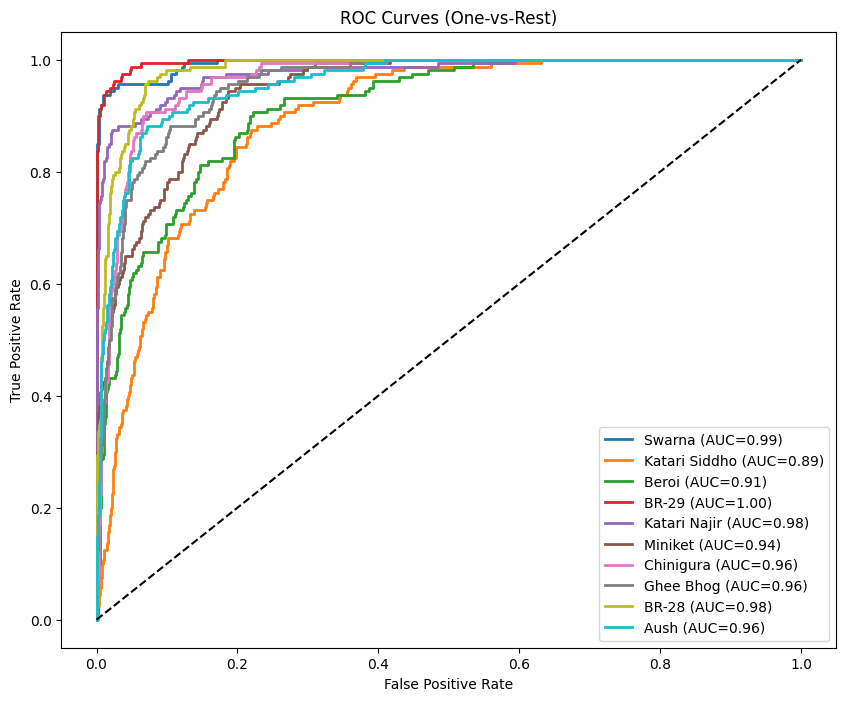

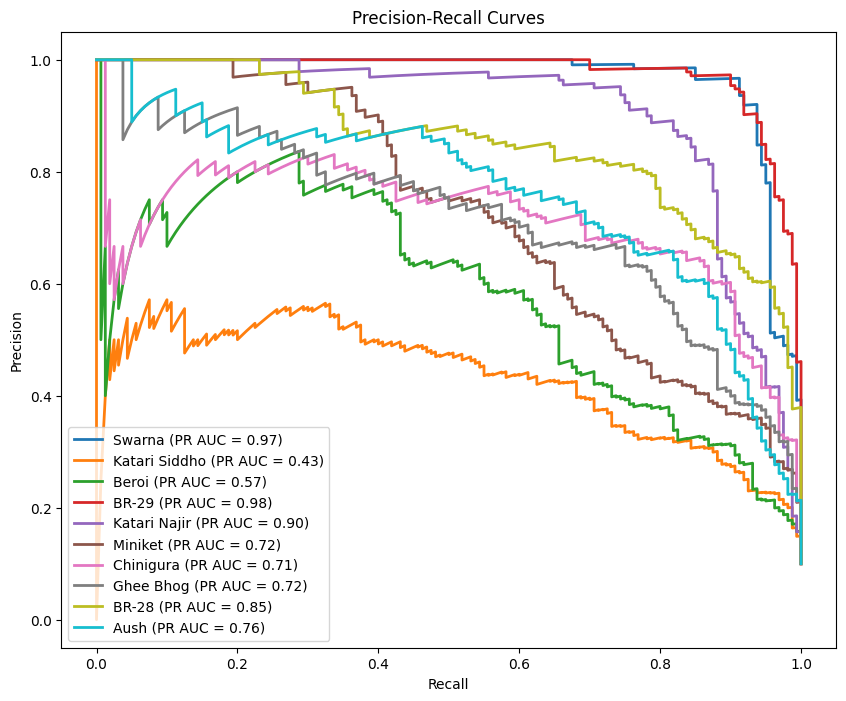


Most confused class pairs:
Swarna is most often confused with Beroi (5 samples)
Katari Siddho is most often confused with BR-28 (59 samples)
Beroi is most often confused with Miniket (67 samples)
BR-29 is most often confused with Swarna (23 samples)
Katari Najir is most often confused with Aush (27 samples)
Miniket is most often confused with Beroi (6 samples)
Chinigura is most often confused with Miniket (117 samples)
Ghee Bhog is most often confused with Miniket (48 samples)
BR-28 is most often confused with Katari Siddho (15 samples)
Aush is most often confused with Beroi (10 samples)


In [32]:
import os
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/image-of-different-processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)
batch_size = 16
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build fine-tuned ResNet50 model
# -----------------------------
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Fine-tune last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)

# -----------------------------
# Compile model
# -----------------------------
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

start_time = time.time()

history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, reduce_lr],
    verbose=2
)

training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time/60:.2f} minutes")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true, y_pred_prob = [], []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"\nMacro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC–AUC Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR Curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [33]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.010347 seconds


In [34]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
print(f"Inference time per sample: {inference_time/test_gen.samples:.6f} sec")
print(f"Total inference time for {test_gen.samples} samples: {inference_time:.2f} sec")

# -----------------------------
# Model parameters summary
# -----------------------------
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Inference time per sample: 0.007729 sec
Total inference time for 1600 samples: 12.37 sec
Total Parameters: 24,641,930
Trainable Parameters: 15,504,394
Non-Trainable Parameters: 9,137,536


Found 360 images belonging to 10 classes.
Found 40 images belonging to 10 classes.
Found 1600 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
12/12 - 71s - 6s/step - accuracy: 0.3306 - loss: 2.2570 - val_accuracy: 0.4500 - val_loss: 1.5922 - learning_rate: 0.0010
Epoch 2/50
12/12 - 3s - 269ms/step - accuracy: 0.5806 - loss: 1.3246 - val_accuracy: 0.6000 - val_loss: 1.1307 - learning_rate: 0.0010
Epoch 3/50
12/12 - 3s - 280ms/step - accuracy: 0.6778 - loss: 0.9980 - val_accuracy: 0.7250 - val_loss: 0.7995 - learning_rate: 0.0010
Epoch 4/50
12/12 - 3s - 265ms/step - accuracy: 0.7361 - loss: 0.7360 - val_accuracy: 0.7000 - val_loss: 0.8497 - learning_rate: 0.0010
Epoch 5/50
12/12 - 3s - 279ms/step - accuracy: 0.7972 - loss: 0.6278 - val_accuracy: 0.7750 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 6/50
12/12 - 3s - 260ms/step - accuracy: 0.8694 - loss: 0.4805 - val_accuracy: 0.7000 - val_loss: 0.6620 - learning_rate: 0.0010
Epoch 7/50
12/1

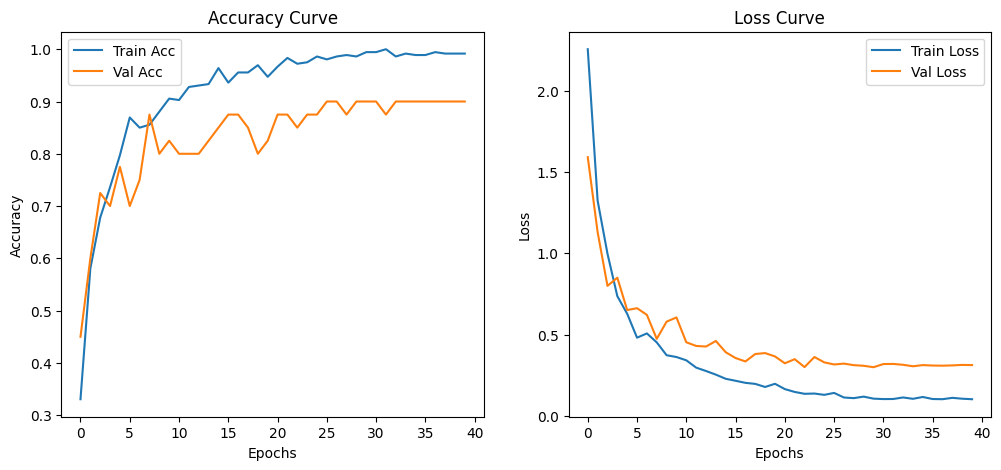


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9750    0.9750    0.9750       160
Katari Siddho     0.7485    0.8000    0.7734       160
        Beroi     0.8452    0.8187    0.8317       160
        BR-29     0.9752    0.9812    0.9782       160
 Katari Najir     0.9458    0.9812    0.9632       160
      Miniket     0.8079    0.8938    0.8487       160
    Chinigura     0.8028    0.7125    0.7550       160
    Ghee Bhog     0.8452    0.8875    0.8659       160
        BR-28     0.9735    0.9187    0.9453       160
         Aush     0.8792    0.8187    0.8479       160

     accuracy                         0.8788      1600
    macro avg     0.8798    0.8787    0.8784      1600
 weighted avg     0.8798    0.8788    0.8784      1600



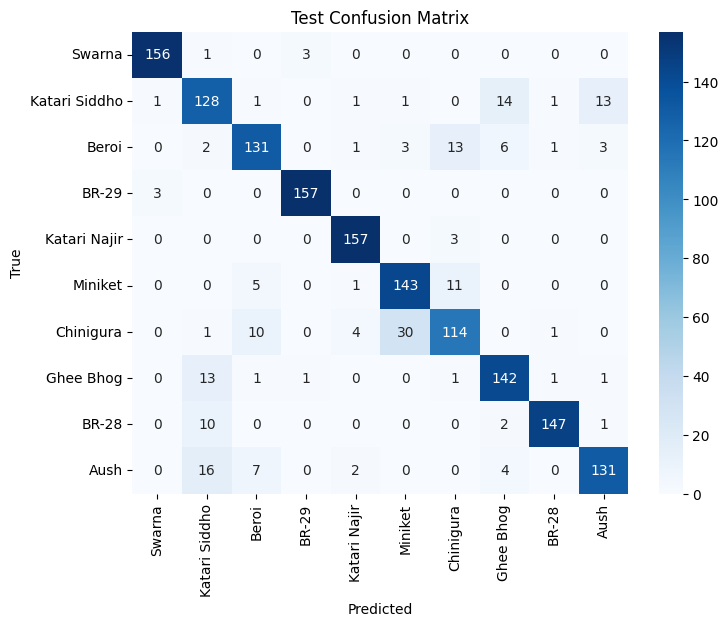

Swarna Accuracy: 0.9750
Katari Siddho Accuracy: 0.8000
Beroi Accuracy: 0.8187
BR-29 Accuracy: 0.9812
Katari Najir Accuracy: 0.9812
Miniket Accuracy: 0.8938
Chinigura Accuracy: 0.7125
Ghee Bhog Accuracy: 0.8875
BR-28 Accuracy: 0.9187
Aush Accuracy: 0.8187


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 23.43 sec
Inference time per sample: 0.014646 sec


In [35]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/image-of-different-processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)  # DenseNet121 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: DenseNet121
# -----------------------------
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # increased epochs
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} sec")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")


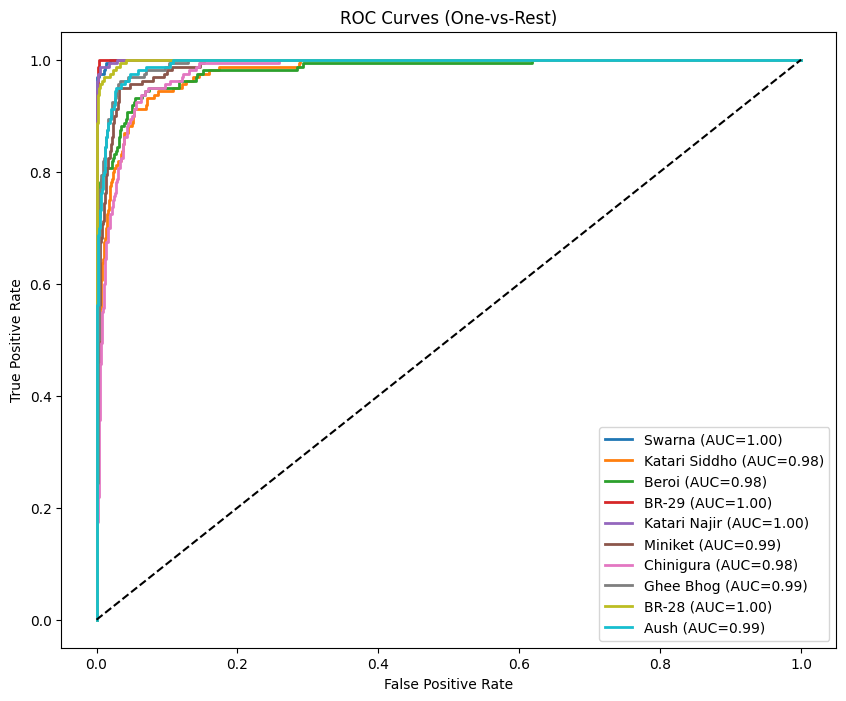

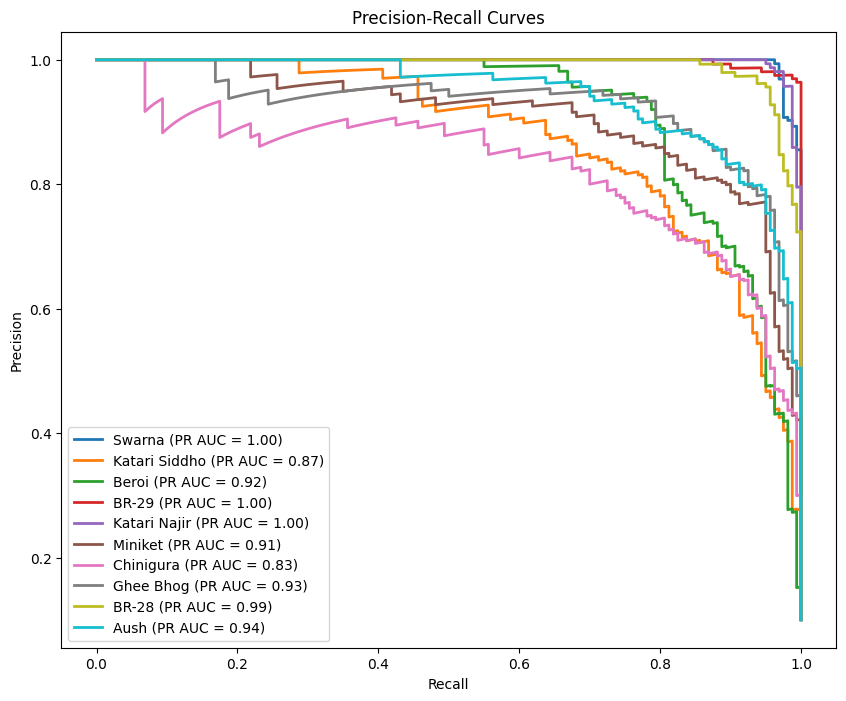


Most confused class pairs:
Swarna is most often confused with BR-29 (3 samples)
Katari Siddho is most often confused with Ghee Bhog (14 samples)
Beroi is most often confused with Chinigura (13 samples)
BR-29 is most often confused with Swarna (3 samples)
Katari Najir is most often confused with Chinigura (3 samples)
Miniket is most often confused with Chinigura (11 samples)
Chinigura is most often confused with Miniket (30 samples)
Ghee Bhog is most often confused with Katari Siddho (13 samples)
BR-28 is most often confused with Katari Siddho (10 samples)
Aush is most often confused with Katari Siddho (16 samples)

Total Training Time: 198.11 sec


In [36]:
 #ROC–AUC curves

y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision–Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

print(f"\nTotal Training Time: {training_time:.2f} sec")

In [37]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


Inference Time per sample: 0.007826 seconds


In [38]:
# -----------------------------
# Calculate and print model parameters
# -----------------------------
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 7,567,434
Trainable Parameters: 529,930
Non-Trainable Parameters: 7,037,504
